# USE CASE

* You have several SKUs that you want to forecast.
* Instead of running them serially, we want to be able to parallelize them.
* **We will use Ray for this demonstration.**
* **The demo will be run on a 8 core machine.**

In [1]:
import time
from typing import Optional
from random import sample
import numpy as np
import pandas as pd
from pandas.testing import assert_series_equal
import matplotlib.pyplot as plt
import ray
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment
from pycaret.datasets import get_data

%matplotlib inline

In [2]:
# Mimic few SKUs
NUM_SKUS = 500
all_data = [get_data(i, folder="time_series/random_walk", verbose=False) for i in np.arange(1, NUM_SKUS+1)]

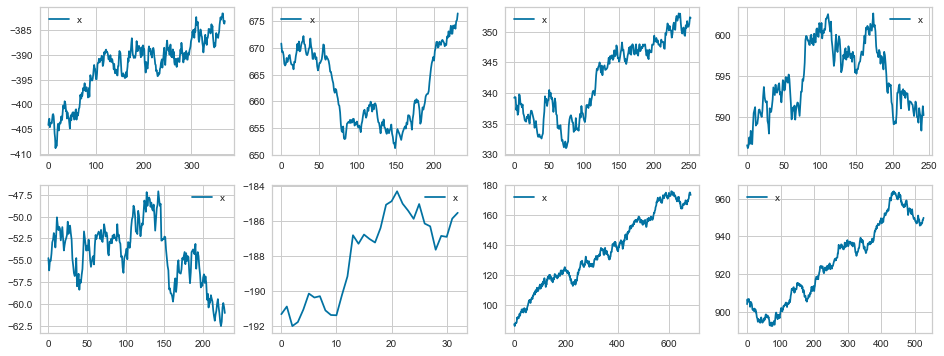

In [3]:
# Plot some SKU data
SAMPLE = 8
subset = sample(all_data, SAMPLE)
fig, axes = plt.subplots(2, 4, figsize=(16,6))
for i, data in enumerate(subset):
    row = int(np.floor(i/4))
    col = i%4
    data.plot(ax=axes[row][col])

In [4]:
# Forecast Specs
FH = 3 # Forecast 3 periods ahead
SP = 1 # No seasonality in data

## Using Native Python

* Uses 8 cores to run the all datasets serially.
* Since Exponential Smoothing does not use multiple cores, we waste 7 cores each time we run this serially

In [5]:
def predict_time_series(data: pd.Series, fh: int = 1, sp: Optional[int] = None, n_jobs: int = 1) -> pd.DataFrame:
    """
    Function that forecasts a time series and returns the predictions
    NOTE: This is a simple example for illustration purposes only.
    Savvy users can make the modeling workflow as customizable as they want.
    """
    exp = TimeSeriesExperiment()
    exp.setup(data=data, fh=fh, seasonal_period=sp, n_jobs=n_jobs, session_id=42)
    model = exp.create_model("exp_smooth")
    predictions = model.predict()
    return predictions

start = time.time()
all_predictions_native = [predict_time_series(data, fh=FH, sp=SP, n_jobs=-1) for data in all_data]
end = time.time()
time_taken = end - start

In [6]:
print(f"Time Taken (Native Python): {time_taken}s")

Time Taken (Native Python): 383.7390880584717s


In [7]:
# all_predictions_native

## Using Ray Parallelization

**Uses 1 core to run the 8 datasets in parallel. Repeat until all datasets are processed.**

In [8]:
predict_time_series_ray = ray.remote(predict_time_series)

start = time.time()
futures = [predict_time_series_ray.remote(data, fh=FH, sp=SP, n_jobs=1) for data in all_data]
all_predictions_ray = ray.get(futures)
end = time.time()
time_taken = end - start

 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:01:46
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:46
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840)                                                                   
 pid=29840)                                                                   
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .            14:01:46
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=29840)                                                                   
 pid=29840)                                                                   
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .            14:01:46
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=26244) Setup Successfully Completed!
 pid=17908) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . .

 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:01:47
 pid=27268) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:01:47
 pid=27268) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Init

 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:01:47
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:01:47
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Init

 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:01:48
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:48
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:48
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:48
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                   
 pid=26244)                                                                   
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .            14:01:48
 pid=26244) Status     . . . . . . . . . . . . . . . . . . 

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:01:48
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:01:48
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=29840)                                                                     
 pid=29840)                    

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:01:48
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:01:48
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Init

 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:01:48
 pid=30644) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852) Setup Successfully Completed!
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:01:49
 pid=30212) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:01:49
 pid=30212) Status     . . . . . . . . . . . . . . . . .

 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:01:49
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:49
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=17908) Setup Successfully Completed!
 pid=25692) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:01:49
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              1

 pid=26244) Setup Successfully Completed!
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:01:49
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:01:49
 pid=17908) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                       

 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:01:50
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:01:50
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)                                                                    
 

 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:01:50
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:50
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=17908)                                                                   
 pid=17908)                                                                   
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .            14:01:50
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=27268)                                                                   
 pid=27268)                                                                   
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .            14:01:50
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=27268)                                                                   
 pid=27268)                                                                   
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .            14:01:50
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=30212) Setup Successfully Completed!
 pid=30644

 pid=26244)                                                                   
 pid=26244)                                                                   
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .            14:01:50
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:01:50
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212) 
 pid=30212)                                                                    
 pid=30212)                                                                    
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .             14:01:50
 pid=30212) Status   

 pid=26244) Setup Successfully Completed!
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:01:51
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:01:51
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                             

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:01:51
 pid=26244) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:01:51
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Init

 pid=29840) ERROR:root:Fit failed on ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) ERROR:root:Cannot use heuristic method with less than 10 observations.
 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe


 pid=17908) Setup Successfully Completed!
 pid=25692) IntProgress(value=0, description='Processing: ', max=3)
 pid=25692)                                                                     
 pid=25692)                                                                     
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .              14:01:52
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=25692)                                                                            
 pid=25692)                                                                            
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:52
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=25692)                                                                            
 pid=25692)                                                                            
 pid=25692) Initiated  . . . . . . . .

 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:52
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                   
 pid=26244)                                                                   
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .            14:01:52
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=26244)                                                                   
 pid=26244)                                                                   
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .            14:01:52
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=17908) IntP

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD86FA0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:01:52
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=27268) Empty DataFrame
 pid=27268) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=27268) Index: []
 pid=27268)                                                                    
 pid=27268)                                                                    
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .             14:01:52
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=27268)  

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=30644) IntProgress(value=0, description='Processing: ', max=4)
 pid=30644)                                                                     
 pid=30644)                                                                     
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .              14:01:52
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30644) Empty DataFrame
 pid=30644) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=30644) Index: []
 pid=30644)                                                                    
 pid=30644)                                                                    
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .             14:01:52
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30644) Estimator  . 

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:53
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:53
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30212)                                                                   
 pid=30212)                                                                   
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .            14:01:53
 pid=30212) Status     . . . . . . . . . . . . . . . . . . 

 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:01:52
 pid=25692) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:01:52
 pid=25692) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                    

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:01:54
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []ries
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:01:54
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=2624

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD493D0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m


 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:01:54
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:54
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:54
 pid=29840) Status     . . . . . . . . . . . . . . . . . . 

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:01:54
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:54
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD493D0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=17908) Setup Successfully Completed!
 pid=29840)                                                                    
 pid=29840)                                                                    
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .             14:01:54
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:01:54
 pid=29840) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                       

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:01:55
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:55
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:01:55
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:01:55
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=27268) I

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ADE7100>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:01:55
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:01:55
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Init

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=29840) Setup Successfully Completed!
 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=21852) IntProgress(value=0, description='Processing: ', max=4)
 pid=21852)                                                                     
 pid=21852)                                                                     
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .              14:01:55
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=21852) Empty DataFrame
 pid=21852) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=21852) Index: []
 pid=21852)                                                                    
 pid=21852)                                                                    
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .             14:01:55
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Sel

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ADE7100>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully


 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:01:56
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:56
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:01:56
 pid=29840) S

 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=17908) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:01:56
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:56
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . .

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:01:56
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:56
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=26244) Setup Successfully Completed!
 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:01:56
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:56
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . .

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD49E20>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m


 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:01:56
 pid=27268) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:01:56
 pid=27268) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Ini

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:01:56
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:01:56
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=30212)                                                                      
 pid=30212)                   

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD49E20>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:01:57
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:01:57
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                    

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:01:57
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:57
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:01:58
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:01:58
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)  

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD43220>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=29840)                                                                   
 pid=29840)                                                                   
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .            14:01:58
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=25692) IntProgress(value=0, description='Processing: ', max=4)
 pid=25692)                                                                     
 pid=25692)                                                                     
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .              14:01:58
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=25692) Empty DataFrame
 pid=25692) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=25692) Index: []
 pid=21852) Setup Successfully Completed!
 pid=17908)                                            

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:01:58
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:01:58
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Init

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD43220>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=17908)                                                                   
 pid=17908)                                                                   
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .            14:01:59
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=17908)                                                                   
 pid=17908)                                                                   
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .            14:01:59
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:01:58
 pid=29840) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=29840) Estimator  . . . . . . . . .

 pid=17908) Setup Successfully Completed!
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:01:58
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268) 
 pid=27268)                                                                            
 pid=27268)                                                                            
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .                     14:01:59
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=27268)                                                                            
 pid=27268)                                                                            
 pid=27

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:01:59
 pid=17908) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:01:59
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Init

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ADF1190>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) Setup Successfully Completed!
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:01:59
 pid=27268) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:01:59
 pid=27268) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                             

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:00
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=25692) IntProgress(value=0, description='Processing: ', max=4)
 pid=25692)                                                                     
 pid=25692)                                                                     
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .              14:02:00
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=25692) Estimator

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ADF1190>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=21852)                                                                   
 pid=21852)                                                                   
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .            14:02:00
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=21852)                                                                   
 pid=21852)                                                                   
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .            14:02:00
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=17908) Setup Successfully Completed!
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:01:59
 pid=30212) Status     . . . . . . . . . . . . . . . . . .       Finalizing Mode

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:00
 pid=21852) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                                   
 pid=25692)                                                                   
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .            14:02:00
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . .

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE0C7C0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=30644) IntProgress(value=0, description='Processing: ', max=4)
 pid=30644)                                                                     
 pid=30644)                                                                     
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .              14:02:01
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30644) Empty DataFrame
 pid=30644) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=30644) Index: []
 pid=30644)                                                                    
 pid=30644)                                                                    
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .             14:02:01
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=25692) I

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)               

 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:00
 pid=21852) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:01
 pid=27268) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Init

 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=29840)                                                                    
 pid=29840)                                                                    
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .             14:02:01
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:01
 pid=29840) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . .

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:02
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:02
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=26244) Setup Successfully Completed!
 pid=30212) Setup Successfully Completed!
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:02
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:02
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                 

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ADE7A60>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:02
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:02
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)  

 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)                                       time_features=[])),
 pid=29840)                 ('imputer',
 pid=29840)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=29840)                                 fill_value_categorical='not_available',
 pid=29840)                                 fill_value_nume...
 pid=29840)                 ('scaling', 'passthrough'), ('P_tra

 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:03
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=29840) Empty DataFrame
 pid=29840) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=29840) Index: []
 pid=29840)                                                                    
 pid=29840)                                                                    
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .             14:02:03
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=29840)  

 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:02
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:02
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Init

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:03
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:03
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model


 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:04
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:04
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)  

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:04
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:04
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . .

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD49640>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:04
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:04
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) Setup Successfully Completed!
 pid=29840) Setup Successfully Completed!
 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=30212)                 

 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)                                       time_features=[])),
 pid=29840)                 ('imputer',
 pid=29840)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=29840)                 

 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:04
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:02:04
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908)  

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=26244) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:02:05
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:05
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . .

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:05
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:05
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)  

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ACB2AC0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:04
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:04
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                    
 pid=30212)                                                                    
 pid=30212) Initiate

 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)                                       time_features=[])),
 pid=29840)               

 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:05
 pid=30644) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:05
 pid=30644) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692) IntProgress(value=0, description='Processing: ', max=3)
 pid=25692)                                                                     
 pid=25692)                    

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:05
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:05
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                    

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=26244)                                                                   
 pid=26244)                                                                   
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .            14:02:06
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=26244)                                                                   
 pid=26244)                                                                   
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .            14:02:06
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:06
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . .

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ADF1040>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:02:06
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=27268) Empty DataFrame
 pid=27268) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=27268) Index: []
 pid=27268)                                                                    
 pid=27268)                                                                    
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .             14:02:06
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=27268)                                                                    
 

 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)   

 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:07
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:07
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)                                                                    
 

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:07
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:07
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=17908) Setup Successfully Completed!
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:07
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:07
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                             

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:07
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:02:07
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908)  

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD43AC0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=21852) Setup Successfully Completed!
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:07
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:07
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840) Setup Successfully Completed!
 pid=27268) IntProgress(value=0, description='Processing: ', max=3)
 pid=27268)                 

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:08
 pid=30644) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:08
 pid=30644) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852) IntProgress(value=0, description='Processing: ', max=4)
 pid=21852)                                                                     
 pid=21852)                    

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:08
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:08
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=30212) Setup Successfully Completed!
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:08
 pid=30644) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:08
 pid=30644) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                           

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:09
 pid=17908) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:09
 pid=17908) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Init

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ADF18B0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:09
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:09
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:02:09
 pid=30212) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:02:09
 pid=30212) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                    

 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)                                       time_features=[])),
 pid=29840)                 ('imputer',
 pid=29840)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=29840)                                 fill_value_categorical='not_available',
 pid=29840)                                 fill_value_nume...
 pid=29840)                 ('scaling', 'passthrough'), ('P_tra

 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:09
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:09
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                   
 pid=26244)                                                                   
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .            14:02:09
 pid=26244) Status     . . . . . . . . . . . . . . . . . . 

 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:02:10
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=27268) Empty DataFrame
 pid=27268) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=27268) Index: []
 pid=27268)                                                                    
 pid=27268)                                                                    
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .             14:02:10
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=30212) S

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:10
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:10
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Init

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=30644) IntProgress(value=0, description='Processing: ', max=3)
 pid=30644)                                                                     
 pid=30644)                                                                     
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .              14:02:10
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30644)                                                                            
 pid=30644)                                                                            
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:10
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30644)                                                                            
 pid=30644)                                                                            
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:10
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:10
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644) Setup Successfully Completed!
 pid=17908)                                                                      
 pid=17908)                                             

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ACB28B0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:11
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:11
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=26244) Setup Successfully Completed!
 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:11
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:11
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . .

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:11
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:11
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)                                                                    
 

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:12
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:02:12
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908)  

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD5F640>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:11
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:11
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                    

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:12
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:11
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644) Setup Successfully Completed!
 pid=26244)                                                                            
 pid=26244)                                                         

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD5F640>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=26244) Setup Successfully Completed!
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:12
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644) IntProgress(value=0, description='Processing: ', max=4)
 pid=30644)                                                                     
 pid=30644)                                                                     
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .              14:02:12
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30644) Empty DataFrame
 pid=30644) Columns: [cutoff, MAE, RMSE, MAPE, 

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:13
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:13
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)  

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:13
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:02:12
 pid=30212) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . .

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ACB29D0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:13
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:13
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) Setup Successfully Completed!
 pid=30644)                                                                      
 pid=30644)                                             

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:13
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:02:13
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908)  

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ACB29D0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           


 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:13
 pid=21852) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=4)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:02:14
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30212) Empty DataFrame
 pid=30212) Columns: [cutoff, MAE, RMSE, MAPE,

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:14
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:14
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Init

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:02:14
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=27268) Empty DataFrame
 pid=27268) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=27268) Index: []
 pid=27268)                                                                    
 pid=27268)                                                                    
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .             14:02:14
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=27268)  

 pid=17908) Setup Successfully Completed!
 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:15
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:15
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . .

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD5F670>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) 
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:15
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:15
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                   
 pid=26244)                                                                   
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .            14:02:15
 pid=26244) Status     . . . . . . . . . . . .

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)               

 pid=29840)                                                                    
 pid=29840)                                                                    
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .             14:02:15
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:15
 pid=29840) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . .

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:15
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:15
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Init

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:15
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:15
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Init

 pid=17908) Setup Successfully Completed!
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:16
 pid=27268) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:16
 pid=27268) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                             

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE7EBE0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:16
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:16
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=26244) Setup Successfully Completed!
 pid=29840) Setup Successfully Completed!
 pid=25692) IntProgress(value=0, description='Processing: ', max=4)
 pid=25692)                                                                     
 pid=25692)                                                                     
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .              14:02:16
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=21852) Setup Successfully Completed!
 pid=25692) Empty DataFrame
 pid=25692) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=25692) Index: []
 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . 

 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)                                       time_features=[])),
 pid=29840)                 ('imputer',
 pid=29840)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=29840)                                 fill_value_categorical='not_available',
 pid=29840)                                 fill_value_nume...
 pid=29840)      

 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:16
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:16
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . .

 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=27268) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=4)
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:16
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:16
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 p

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:16
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:16
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                    

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE460A0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=25692) Setup Successfully Completed!
 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:17
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:17
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . .

 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:17
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:18
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=29840) Empty DataFrame
 pid=29840) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=29840) Index: []
 pi

 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:18
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:18
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)  

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model


 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:02:18
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=27268) Empty DataFrame
 pid=27268) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=27268) Index: []
 pid=27268)                                                                    
 pid=27268)                                                                    
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .             14:02:18
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=27268)  

 pid=17908) Setup Successfully Completed!
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:02:18
 pid=30212) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:02:18
 pid=30212) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                             

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ACB2790>, targe

 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:19
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:02:19
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908)                                                                    
 

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=30644)                                                                            
 pid=30644)                                                                            
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:19
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30644)                                                                            
 pid=30644)                                                                            
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:19
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=25692) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                    

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ACB2790>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=30644) Setup Successfully Completed!
 pid=21852) IntProgress(value=0, description='Processing: ', max=3)
 pid=21852)                                                                     
 pid=21852)                                                                     
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .              14:02:19
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=21852)                                                                            
 pid=21852)                                                                            
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:19
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=21852)                                                                            
 pid=21852)                                               

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:19
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:19
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Init

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:20
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:20
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD5A4C0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=17908) Setup Successfully Completed!
 pid=25692) IntProgress(value=0, description='Processing: ', max=3)
 pid=25692)                                                                     
 pid=25692)                                                                     
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .              14:02:20
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=25692)                                                                            
 pid=25692)                                                                            
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:20
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=25692)                                                                            
 pid=25692)                                                                            
 pid=25692) Initiated  . . . . . . . .

 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)                                       time_features=[])),
 pid=29840)                 ('imputer',
 pid=29840)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=29840)                                 fill_value_categorical='not_available',
 pid=29840)                                 fill_value_nume...
 pid=29840)                 ('scaling', 'passthrough'), ('P_tra

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:20
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:20
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Init

 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:20
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:20
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                           

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model


 pid=17908)                                                                   
 pid=17908)                                                                   
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .            14:02:21
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=17908)                                                                   
 pid=17908)                                                                   
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .            14:02:21
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:02:21
 pid=27268) Status     . . . . . . . . . . . . . . . . . 

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD5A9A0>, targe

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:21
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:21
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)          

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying data for preprocessing
 pid=29840) INFO:logs:Declaring preprocessing parameters
 pid=29840) INFO:logs:Creating preprocessing pipeline
 pid=29840) INFO:logs:Preprocessing pipeline created successfully
 pid=29840) ERROR:logs:(Process Exit): setup has been interupted with user command 'quit'. setup must rerun.
 pid=29840) INFO:logs:Creating global containers
 pid=29840) INFO:logs:Internal pipeline: Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False)
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBR

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:21
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:21
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840) Setup Successfully Completed!
 pid=27268)                                                                      
 pid=27268)                                             

 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)                                       time_features=[])),
 pid=29840)                 ('imputer',
 pid=29840)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=29840)                                 fill_value_categorical='not_available',
 pid=29840) 

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:21
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:21
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Init

 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=27268) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:02:22
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:21
 pid=30644) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                               

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:22
 pid=27268) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:22
 pid=27268) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Init

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD5A4C0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:22
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:22
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        


 pid=21852) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:22
 pid=21852) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:22
 pid=21852) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)    

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD5A4C0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:22
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:22
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                           

 pid=17908) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=4)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:02:23
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30212) Empty DataFrame
 pid=30212) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=30212) Index: []
 pid=30212)                                                                    
 pid=30212)                                                                    
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .             14:02:23
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30212) Estimator  . . . . . . . . . . . . . . 

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model


 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:23
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:23
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                                   
 pid=25692)                                                                   
 pid=25692) Initiated 

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:02:23
 pid=30212) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:02:23
 pid=30212) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                     
 pid=29840)                    

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD5A9A0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:24
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:24
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:24
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=29840) Empty DataFrame
 pid=29840) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=29840) Index: []
 pid=29840)                                                                    
 pid=29840)                                                                    
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .             14:02:24
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=29840)  

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:25
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:25
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Init

 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:25
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                    
 pid=30644)                                                                    
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .             14:02:25
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . .

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=25692) IntProgress(value=0, description='Processing: ', max=4)
 pid=25692)                                                                     
 pid=25692)                                                                     
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .              14:02:25
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=25692) Empty DataFrame
 pid=25692) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=25692) Index: []
 pid=25692)                                                                    
 pid=25692)                                                                    
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .             14:02:25
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=21852) S

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD43E50>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:26
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:26
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=26244) Setup Successfully Completed!
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:25
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:25
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=29840)                                                           

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD43E50>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:26
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:26
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)  

 pid=17908) Setup Successfully Completed!
 pid=25692) Setup Successfully Completed!
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:25
 pid=21852) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:25
 pid=21852) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)   

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:26
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:26
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                    

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ADC7130>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:27
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:27
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=26244) Setup Successfully Completed!
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:27
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:27
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840) Setup Successfully Completed!
 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                 

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:27
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:27
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)  

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ADC7130>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=17908) Setup Successfully Completed!
 pid=30212)                                                                   
 pid=30212)                                                                   
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .            14:02:27
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=25692) IntProgress(value=0, description='Processing: ', max=3)
 pid=25692)                                                                     
 pid=25692)                                                                     
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .              14:02:28
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=25692)                                                                            
 pid=25692)                                                                            
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .                

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:28
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:28
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AEEE4F0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) Setup Successfully Completed!
 pid=29840) Setup Successfully Completed!
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:02:28
 pid=30212) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644) Setup Successfully Completed!
 pid=21852)                                                                   
 pid=21852)                                                                   
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .            14:02:28
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=21852)                                                                   
 pid=21852)                                                          

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:29
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:29
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Init

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:02:29
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=27268) Empty DataFrame
 pid=27268) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=27268) Index: []
 pid=27268)                                                                    
 pid=27268)                                                                    
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .             14:02:29
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=27268)  

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:29
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:29
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                    

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD49E50>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:29
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:29
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . .

 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)                                       time_features=[])),
 pid=29840)                 ('imputer',
 pid=29840)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=29840)                                 fill_value_categorical='not_available',
 pid=29840)                                 fill_value_nume...
 pid=29840)                 ('scaling', 'passthrough'), ('P_tra

 pid=26244) Setup Successfully Completed!
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:30
 pid=17908) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:30
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                             

 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:30
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:30
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)  

 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:30
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:30
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                    
 pid=27268)                                                                    
 pid=27268) Initiate

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:30
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:30
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE7EA30>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:31
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:31
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:02:31
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:02:31
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . .

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE7EA30>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:31
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:31
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Init

 pid=27268) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:02:31
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:31
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . .

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:32
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:32
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:31
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:31
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) Setup Successfully Completed!
 pid=30212)                                                                     
 pid=30212)                                              

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE68700>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:02:32
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:32
 pid=17908) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . .

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:32
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:32
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                   
 pid=26244)                                                                   
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .            14:02:32
 pid=26244) Status     . . . . . . . . . . . . . . . . . . 

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE68700>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=30212)                                                                   
 pid=30212)                                                                   
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .            14:02:33
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=30212)                                                                   
 pid=30212)                                                                   
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .            14:02:33
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=30644) Setup Successfully Completed!
 pid=30644) me_series
 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=30644) ERROR:root:Fit failed on ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30644)                      initial_seasonal=None, initial_trend=None,
 pid=30644)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30644)                      trend='add', use_boxcox=None)
 pid=30644) ERROR:root:Cannot use heuristic method with less than 10 observations.
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=

 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:02:33
 pid=30212) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:02:33
 pid=30212) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Init

 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Finalizing model
 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AEEE070>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=

 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:34
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:34
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30644) INFO:logs:Logging name: ts-default-name
 pid=30644) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30644) INFO:logs:version 3.0.0
 pid=30644) INFO:logs:Initializing setup()
 pid=30644) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FB9E760>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=Fal

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:34
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:34
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AEEE070>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30

 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:34
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=29840) Empty DataFrame
 pid=29840) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=29840) Index: []
 pid=29840)                                                                    
 pid=29840)                                                                    
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .             14:02:34
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=29840)                                                                    
 

 pid=30644) INFO:logs:Importing untrained model
 pid=30644) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:Starting cross validation
 pid=30644) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30644)             step_length=3), n_jobs=1


 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:34
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:34
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Init

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Finalizing model


 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:34
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:34
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                    

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30644)                      initial_seasonal=None, initial_trend=None,
 pid=30644)               

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:35
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:35
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying data for preprocessing
 pid=29840) INFO:logs:Declaring preprocessing parameters
 pid=29840) INFO:logs:Creating preprocessing pipeline
 pid=29840) INFO:logs:Preprocessing pipeline created successfully
 pid=29840) ERROR:logs:(Process Exit): setup has been interupted with user command 'quit'. setup must rerun.
 pid=29840) INFO:logs:Creating global containers
 pid=29840) INFO:logs:Internal pipeline: Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False)
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying data for preprocessing
 pid=30644) INFO:logs:Declaring preprocessing parameters
 pid=30644) INFO:logs:Creating preprocessing pipeline
 pid=30644) INFO:logs:Preprocessing pipeline created successfully
 pid=30644) ERROR:logs:(Process Exit): setup has been interupted with user command 'quit'. setup must rerun.
 pid=30644) INFO:logs:Creating global containers
 pid=30644) INFO:logs:I

 pid=26244) Setup Successfully Completed!
 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:35
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:02:35
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . 

 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)                                       time_features=[])),
 pid=29840)                 ('imputer',
 pid=29840)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=29840)                                 fill_value_categorical='not_available',
 pid=29840)                                 fill_value_nume...
 pid=29840)                 ('scaling', 'passthrough'), ('P_tra


 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:35
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:35
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)                                                                    
 pid=26244)                                                                    
 

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:36
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=29840) Empty DataFrame
 pid=29840) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=29840) Index: []
 pid=29840)                                                                    
 pid=29840)                                                                    
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .             14:02:36
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=29840)                                                                    
 

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:35
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:35
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Init

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=3

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:36
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:36
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AF1BF40>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) Setup Successfully Completed!
 pid=29840)                                                                   
 pid=29840)                                                                   
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .            14:02:36
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=30644) IntProgress(value=0, description='Processing: ', max=3)
 pid=30644)                                                                     
 pid=30644)                                                                     
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .              14:02:36
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30644)                                                                            
 pid=30644)                                                                            
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .                

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor

 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:37
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:37
 pid=26244) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . .

 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1
 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FBBA640>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30644) INFO:logs:Checking exceptions
 pid=30644) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644

 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:02:37
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:37
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:37
 pid=30644

 pid=30644) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:Starting cross validation
 pid=30644) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30644)             step_length=3), n_jobs=1


 pid=30212) Setup Successfully Completed!
 pid=21852) IntProgress(value=0, description='Processing: ', max=3)
 pid=21852)                                                                     
 pid=21852)                                                                     
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .              14:02:37
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=21852)                                                                            
 pid=21852)                                                                            
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:37
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=21852)                                                                            
 pid=21852)                                                                            
 pid=21852) Initiated  . . . . . . . .

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:02:38
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=27268) Empty DataFrame
 pid=27268) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=27268) Index: []
 pid=27268)                                                                    
 pid=27268)                                                                    
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .             14:02:38
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=30212) I

 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:38
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:38
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AEF8A30>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) Setup Successfully Completed!
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:38
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:38
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644) IntProgress(value=0, description='Processing: ', max=3)
 pid=30644)                                                           

 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)                                       time_features=[])),
 pid=29840)                 ('imputer',
 pid=29840)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=29840)                                 fill_value_categorical='not_available',
 pid=29840)                                 fill_value_nume...
 pid=29840)                 ('scaling', 'passthrough'), ('P_tra

 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:38
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:38
 pid=29840) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                            

 pid=30644) INFO:logs:self.master_model_container: 0
 pid=30644) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1
 pid=30644) INFO:logs:Pipeline(memory=None,
 pid=30644)          steps=[('dtypes',
 pid=30644)                  DataTypes_Auto_infer(categorical_features=[],
 pid=30644)                                       display_types=False, features_todrop=[],
 pid=30644)                                       float_dtype='float64', id_columns=[],
 pid=30644)                                       ml_usecase='regression',
 pid=30644)                                       numerical_features=[], target='x',
 pid=30644)                                       time_features=[])),
 pid=30644)                 ('imputer',
 pid=30644)                  Simple_Imputer(categorical_strategy='most frequent',
 pi

 pid=30644) IntProgress(value=0, description='Processing: ', max=4)
 pid=30644)                                                                     
 pid=30644)                                                                     
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .              14:02:39
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30644) Empty DataFrame
 pid=30644) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=30644) Index: []
 pid=30644)                                                                    
 pid=30644)                                                                    
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .             14:02:39
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=30644)  

 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FB3CAC0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30644) INFO:logs:Checking exceptions
 pid=30644) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644) INFO:logs:Defining folds
 pid=30644) INFO:logs:Declaring metric variables
 pid=30644) INFO:logs:Importing untrained model
 pid=30644) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:Starting cross validation
 pid=30644) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30644)           

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:38
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:38
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                    

 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Finalizing model
 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30644)                      initial_seasonal=None, initial_trend=None,
 pid=30644)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30644)                      trend='add', use_boxcox=None)
 pid=30644) INFO:logs:create_model() successfully completed......................................


 pid=30212) Setup Successfully Completed!
 pid=21852) Setup Successfully Completed!
 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:39
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:39
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                         

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=30644) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30644) INFO:logs:Logging name: ts-default-name
 pid=30644) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30644) INFO:logs:version 3.0.0
 pid=30644) INFO:logs:Initializing setup()
 pid=30644) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FAC6BB0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=

 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:39
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:39
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import sktime.forecastin

 pid=17908) Setup Successfully Completed!
 pid=30644) Setup Successfully Completed!
 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:40
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:40
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=2624

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ADE7CD0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=25692) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:40
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:40
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . .

 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)   

 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:02:40
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=27268) Empty DataFrame
 pid=27268) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=27268) Index: []
 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:40
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840) Estimator

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ADE7CD0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           


 pid=21852)                                                                            
 pid=21852)                                                                            
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:40
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=21852)                                                                   
 pid=21852)                                                                   
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .            14:02:40
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=21852)                                                                   
 pid=21852)                                                                   
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .            14:02:40
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=17908)    

 pid=30212) Setup Successfully Completed!
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:02:40
 pid=25692) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:02:40
 pid=25692) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=27268)                                                           

 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30644)                      initial_seasonal=None, initial_trend=None,
 pid=30644)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30644)                      trend='add', use_boxcox=None)
 pid=30644) INFO:logs:create_model() successfully completed......................................


 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:41
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:41
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=30644) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30644) INFO:logs:Logging name: ts-default-name
 pid=30644) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30644) INFO:logs:version 3.0.0
 pid=30644) INFO:logs:Initializing setup()
 pid=30644) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FB00220>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=

 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                   
 pid=27268)                                                                   
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .            14:02:41
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=27268)                                                                   
 pid=27268)                                                                   
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .            14:02:41
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=30644) Setup Successfully Completed!
 pid=25692)                                                                   
 pid=25692)                                                                   
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .            14:02:41
 pid=25692) Status   

 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) INFO:logs:Creating grid variables
 pid=30644) INFO:logs:self.master_model_container: 0
 pid=30644) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.

 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:41
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:41
 pid=26244) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . .

 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FB00220>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30644) INFO:logs:Checking exceptions
 pid=30644) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644) INFO:logs:Defining folds
 pid=30644) INFO:logs:Declaring metric variables
 pid=30644) INFO:logs:Importing untrained model
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.Ca

 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:02:42
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:42
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=30212) Setup Successfully Completed!
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:41
 pid=30644) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:41
 pid=30644) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                             

 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Finalizing model
 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30644)                      initial_seasonal=None, initial_trend=None,
 pid=30644)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30644)                      trend='add', use_boxcox=None)
 pid=30644) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe


 pid=17908)                                                                   
 pid=17908)                                                                   
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .            14:02:42
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=17908)                                                                   
 pid=17908)                                                                   
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .            14:02:42
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:42
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . .

 pid=29840) INFO:logs:Finalizing model
 pid=30644) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30644) INFO:logs:Logging name: ts-default-name
 pid=30644) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30644) INFO:logs:version 3.0.0
 pid=30644) INFO:logs:Initializing setup()
 pid=30644) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FB270A0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:42
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:42
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE8FD90>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) Setup Successfully Completed!
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:42
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:42
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                             

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:43
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:43
 pid=27268) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                      
 pid=27268)                             

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1



 pid=25692) Setup Successfully Completed!
 pid=21852) IntProgress(value=0, description='Processing: ', max=3)
 pid=21852)                                                                     
 pid=21852)                                                                     
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .              14:02:43
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=21852)                                                                            
 pid=21852)                                                                            
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:43
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=21852)                                                                            
 pid=21852)                                                                            
 pid=21852) Initiated  . . . . . . . 

 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Finalizing model
 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30644)                      initial_seasonal=None, initial_trend=None,
 pid=30644)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30644)                      trend='add', use_boxcox=None)
 pid=30644) INFO:logs:create_model() successfully completed......................................


 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:43
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:43
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30644) INFO:logs:Logging name: ts-default-name
 pid=30644) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30644) INFO:logs:version 3.0.0
 pid=30644) INFO:logs:Initializing setup()
 pid=30644) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FA44D90>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnso

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:43
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:43
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=4)
 pid=21852)                                                           

 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) INFO:logs:Creating grid variables
 pid=30644) INFO:logs:self.master_model_container: 0
 pid=30644) INFO:logs:self.display_container: 1
 pid=30644) INFO:logs:Pipeline(memory=None,
 pid=30644)          steps=[('dtypes',
 pid=30644)                  DataTypes_Auto_infer(categorical_features=[],
 pid=30644)                                       display_types=False, features_todrop=[],
 pid=30644)                                       float_dtype='float64', id_columns=[],
 pid=30644)                                       ml_usecase='regression',
 pid=30644)                                       numerical_features=[], target='x',
 pid=30644)               

 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:44
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:02:44
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908)  

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE46E20>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=29840) Setup Successfully Completed!
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:44
 pid=30644) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:02:43
 pid=25692) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                                      
 pid=25692)                                             

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:44
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:44
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                    
 pid=29840)                     

 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:45
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:45
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Finalizing model


 pid=17908) Setup Successfully Completed!
 pid=30212)                                                                   
 pid=30212)                                                                   
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .            14:02:45
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:45
 pid=21852) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .          

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30644)                      initial_seasonal=None, initial_trend=None,
 pid=30644)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30644)                      trend='add', use_boxcox=None)
 pid=30644) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:Finalizing model
 pid=30644) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30644) INFO:logs:Logging name: ts-default-name
 pid=30644) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30644) INFO:logs:version 3.0.0
 pid=30644) INFO:logs:Initializing setup()
 pid=30644) INF

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:45
 pid=17908) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:45
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Init

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD5EA30>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:45
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:45
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606F

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:46
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=27268) Setup Successfully Completed!
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:45
 pid=30644) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=30644) Estimator  . . . . . . . . . . 

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD5EA30>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully


 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:46
 pid=29840) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                    
 pid=27268)                                                                    
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .             14:02:46
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=29840)                                                                      
 pid=29840)                 

 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1
 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Finalizing model
 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30644)                      initial_seasonal=None, initial_trend=None,
 pid=30644)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30644)                      trend='add', use_boxcox=None)
 pid=30644) INFO:logs:create_model() successfully completed......................................


 pid=25692) IntProgress(value=0, description='Processing: ', max=4)
 pid=25692)                                                                     
 pid=25692)                                                                     
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .              14:02:46
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=25692) Empty DataFrame
 pid=25692) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=25692) Index: []
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:46
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pi

 pid=30644) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30644) INFO:logs:Logging name: ts-default-name
 pid=30644) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30644) INFO:logs:version 3.0.0
 pid=30644) INFO:logs:Initializing setup()
 pid=30644) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FBFA130>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:46
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:46
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Init

 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) INFO:logs:Creating grid variables
 pid=30644) INFO:logs:self.master_model_container: 0
 pid=30644) INFO:logs:self.display_container: 1
 pid=30644) INFO:logs:Pipeline(memory=None,
 pid=30644)          steps=[('dtypes',
 pid=30644)   

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:47
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:47
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Finalizing model
 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FBFA130>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30644) INFO:logs:Checking exceptions
 pid=30644) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644) INFO:logs:Defining folds
 pid=30644) INFO:logs:Declaring metric variables
 pid=30644) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid

 pid=27268)                                                                   
 pid=27268)                                                                   
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .            14:02:47
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:47
 pid=30644) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:47
 pid=30644) Status     . . .

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AF4E790>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=29840) Setup Successfully Completed!
 pid=25692) Setup Successfully Completed!
 pid=21852) Setup Successfully Completed!
 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:47
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:02:47
 pid=17908) Status     . . . . . . . . . . . . 

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=306

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:47
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:47
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiate

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AF4E790>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=30644) WARNING:logs:catboost not found
 pid=30644) INFO:logs:mlflow==1.22.0
 pid=30644) INFO:logs:Checking Exceptions
 pid=30644) INFO:logs:Declaring global variables
 pid=30644) INFO:logs:self.USI: cdc2
 pid=30644) INFO:logs:self.variable_k

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:48
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:48
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=30644) INFO:logs:self.master_model_container: 0
 pid=30644) INFO:logs:self.display_container: 1
 pid=30644) INFO:logs:Pipeline(memory=None,
 pid=30644)          steps=[('dtypes',
 pid=30644)                  DataTypes_Auto_infer(categorical_features=[],
 pid=30644)                                       display_types=False, features_todrop=[],
 pid=30644)                                       float_dtype='float64', id_columns=[],
 pid=30644)                                       ml_usecase='regression',
 pid=30644)                                       numerical_features=[], target='x',
 pid=30644)                                       time_features=[])),
 pid=30644)                 ('imputer',
 pid=30644)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=30644)                                 fill_value_categorical='not_available',
 pid=30644)                                 fill_value_nume...
 pid=30644)                 ('scaling', 'passthrough'), ('P_tra

 pid=26244) Setup Successfully Completed!
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:47
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:47
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                             

 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=30644) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:Starting cross validation
 pid=30644) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30644)             step_length=3), n_jobs=1


 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:48
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:48
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)                                                                            
 pid=29840)                                    

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AF1B400>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:48
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:48
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Init

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Finalizing model
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)   

 pid=17908) Setup Successfully Completed!
 pid=25692) IntProgress(value=0, description='Processing: ', max=4)
 pid=25692)                                                                     
 pid=25692)                                                                     
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .              14:02:49
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=25692) Empty DataFrame
 pid=25692) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=25692) Index: []
 pid=25692)                                                                    
 pid=25692)                                                                    
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .             14:02:49
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=25692) Estimator  . . . . . . . . . . . . . . 

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AF1B400>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:49
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:49
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=298

 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) INFO:logs:Creating grid variables
 pid=30644) INFO:logs:self.master_model_container: 0
 pid=30644) INFO:logs:self.display_container: 1
 pid=30644) INFO:logs:Pipeline(memory=None,
 pid=30644)          steps=[('dtypes',
 pid=30644)                  DataTypes_Auto_infer(categorical_features=[],
 pid=30644)                        

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:49
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:49
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FC0C160>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30644) INFO:logs:Checking exceptions
 pid=30644) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644) INFO:logs:Defining folds
 pid=30644) INFO:logs:Declaring metric variables
 pid=30644) INFO:logs:Importing untrained model
 pid=30644) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:Starting cross validation
 pid=30644) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30644)           

 pid=26244) Setup Successfully Completed!
 pid=27268) Setup Successfully Completed!
 pid=30212) Setup Successfully Completed!
 pid=30644)                                                                    
 pid=30644)                                                                    
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .             14:02:50
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=30644)                                                                    
 pid=30644)                                                                    
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .             14:02:50
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=30644)                                                               

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model



 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:02:50
 pid=30212) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:50
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:50
 pid=27268) Sta

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD6ECA0>, targe

 pid=21852) IntProgress(value=0, description='Processing: ', max=3)
 pid=21852)                                                                     
 pid=21852)                                                                     
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .              14:02:50
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=21852)                                                                            
 pid=21852)                                                                            
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:50
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:50
 pid=26244

 pid=29840)                                                                   
 pid=29840)                                                                   
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .            14:02:50
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:50
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:02:50
 pid=27268) Status     . . .

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)   

 pid=17908) Setup Successfully Completed!
 pid=30212)                                                                   
 pid=30212)                                                                   
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .            14:02:51
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=30212)                                                                   
 pid=30212)                                                                   
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .            14:02:51
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=25692) IntProgress(value=0, description='Processing: ', max=4)
 pid=25692)                                                                     
 pid=25692)                                                                     
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .              14:02:51
 pid=25692) Sta

 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30644)                      initial_seasonal=None, initial_trend=None,
 pid=30644)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30644)                      trend='add', use_boxcox=None)
 pid=30644) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD6ECA0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_mod

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:51
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:02:51
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . 

 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1
 pid=30644) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30644) INFO:logs:Logging name: ts-default-name
 pid=30644) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30644) INFO:logs:version 3.0.0
 pid=30644) INFO:logs:Initializing setup()
 pid=30644) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FB7EE20>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_

 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:02:51
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=27268) Empty DataFrame
 pid=27268) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=27268) Index: []
 pid=27268)                                                                    
 pid=27268)                                                                    
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .             14:02:51
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=30644) S

 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) INFO:logs:Creating grid variables
 pid=30644) INFO:logs:self.master_model_container: 0
 pid=30644) INFO:logs:self.display_container: 1
 pid=30644) INFO:logs:Pipeline(memory=None,
 pid=30644)          steps=[('dtypes',
 pid=30644)                  DataTypes_Auto_infer(categorical_features=[],
 pid=30644)                        

 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:51
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:51
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644) IntProgress(value=0, description='Processing: ', max=4)
 pid=30644)                                                                     
 pid=30644)                    

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:51
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:02:51
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Init

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AF40520>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:51
 pid=30644) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:51
 pid=30644) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692) IntProgress(value=0, description='Processing: ', max=4)
 pid=25692)                                                                     
 pid=25692)                    

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)               

 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                   
 pid=30212)                                                                   
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .            14:02:52
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:52
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                  

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30644) INFO:logs:Logging name: ts-default-name
 pid=30644) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30644) INFO:logs:version 3.0.0
 pid=30644) INFO:logs:Initializing setup()
 pid=30644) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FB27CA0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeri

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:52
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:52
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Init

 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) INFO:logs:Creating grid variables
 pid=30644) INFO:logs:self.master_model_container: 0
 pid=30644) INFO:logs:self.display_container: 1
 pid=30644) INFO:logs:Pipeline(memory=None,
 pid=30644)          steps=[('dtypes',
 pid=30644)                  DataTypes_Auto_infer(categorical_features=[],
 pid=30644)                        

 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:53
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:02:53
 pid=30212) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                        

 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FB27CA0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30644) INFO:logs:Checking exceptions
 pid=30644) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644) INFO:logs:Defining folds
 pid=30644) INFO:logs:Declaring metric variables
 pid=30644) INFO:logs:Importing untrained model
 pid=30644) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into 

 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:52
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:52
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Init

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:53
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:53
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AF05C70>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) Setup Successfully Completed!
 pid=29840) Setup Successfully Completed!
 pid=30212)                                                                   
 pid=30212)                                                                   
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .            14:02:53
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:02:53
 pid=25692) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . .

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:54
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:54
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)  

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AF05C70>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=17908) Setup Successfully Completed!
 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:02:54
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=27268) Empty DataFrame
 pid=27268) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=27268) Index: []
 pid=27268)                                                                    
 pid=27268)                                                                    
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .             14:02:54
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . 

 pid=30212) ERROR:root:Fit failed on ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30212)                      initial_seasonal=None, initial_trend=None,
 pid=30212)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30212)                      trend='add', use_boxcox=None)
 pid=30212) ERROR:root:Cannot use heuristic method with less than 10 observations.
 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FA48F40>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30644) INFO:logs:Checking exceptions
 pid=30644) INFO:logs:Preparing display monitor
 pid=30212) INFO:logs:Calculating mean and std
 pid=30212) I

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:54
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:54
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                    

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=30212) INFO:logs:Finalizing model
 pid=30212) INFO:logs:Uploading results into container
 pid=30212) INFO:logs:Uploading model into container now
 pid=30212) INFO:logs:master_model_container: 1
 pid=30212) INFO:logs:display_container: 2
 pid=30212) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30212)                      initial_seasonal=None, initial_trend=None,
 pid=30212)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30212)                      trend='add', use_boxcox=None)
 pid=30212) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840)

 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:02:55
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:55
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     1


 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) INFO:logs:Creating grid variables
 pid=30644) INFO:logs:Finalizing model
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegr

 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:55
 pid=21852) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:55
 pid=21852) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)     

 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)                                       time_features=[])),
 pid=29840)                 ('imputer',
 pid=29840)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=29840)                                 fill_value_categorical='not_available',
 pid=29840)                                 fill_value_nume...
 pid=29840)                 ('scaling', 'passthrough'), ('P_tra

 pid=30644) IntProgress(value=0, description='Processing: ', max=3)
 pid=30644)                                                                     
 pid=30644)                                                                     
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .              14:02:55
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30644)                                                                            
 pid=30644)                                                                            
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:55
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30644)                                                                            
 pid=30644)                                                                            
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=30644) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying data for preprocessing
 pid=30644) INFO:logs:Declaring preprocessing parameters
 pid=30644) INFO:logs:Creating preprocessing pipeline
 pid=30644) INFO:logs:Preprocessing pipeline created successfully
 pid=30644) ERROR:logs:(Process Exit): setup has been interupted with user command 'quit'. setup must rerun.
 pid=30644) INFO:logs:Creating global containers
 pid=30644) INFO:logs:Internal pipeline: Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False)
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNIN

 pid=27268) Setup Successfully Completed!
 pid=25692) IntProgress(value=0, description='Processing: ', max=3)
 pid=25692)                                                                     
 pid=25692)                                                                     
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .              14:02:56
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=25692)                                                                            
 pid=25692)                                                                            
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:56
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=25692)                                                                            
 pid=25692)                                                                            
 pid=25692) Initiated  . . . . . . . .

 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FB3DF40>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30644) INFO:logs:Checking exceptions
 pid=30644) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644) INFO:logs:Defining folds
 pid=30644) INFO:logs:Declaring metric variables
 pid=30644) INFO:logs:Importing untrained model
 pid=30212) INFO:logs:Calculating mean and std
 pid=30212) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=30212) INF

 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:55
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:02:55
 pid=29840) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Init

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=30212) INFO:logs:Uploading results into container
 pid=30212) INFO:logs:Uploading model into container now
 pid=30212) INFO:logs:master_model_container: 1
 pid=30212) INFO:logs:display_container: 2
 pid=30212) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30212)                      initial_seasonal=None, initial_trend=None,
 pid=30212)               

 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:56
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:56
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=25692)                                                                     
 pid=25692)                                                                     
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .              14:02:56
 pid=25692) S

 pid=30212) INFO:logs:Importing libraries
 pid=30212) INFO:logs:Copying data for preprocessing
 pid=30212) INFO:logs:Declaring preprocessing parameters
 pid=30212) INFO:logs:Creating preprocessing pipeline
 pid=30212) INFO:logs:Preprocessing pipeline created successfully
 pid=30212) ERROR:logs:(Process Exit): setup has been interupted with user command 'quit'. setup must rerun.
 pid=30212) INFO:logs:Creating global containers
 pid=30212) INFO:logs:Internal pipeline: Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False)
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBR


 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:56
 pid=21852) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:56
 pid=21852) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . 

 pid=30212) INFO:logs:self.master_model_container: 0
 pid=30212) INFO:logs:self.display_container: 1
 pid=30212) INFO:logs:Pipeline(memory=None,
 pid=30212)          steps=[('dtypes',
 pid=30212)                  DataTypes_Auto_infer(categorical_features=[],
 pid=30212)                                       display_types=False, features_todrop=[],
 pid=30212)                                       float_dtype='float64', id_columns=[],
 pid=30212)                                       ml_usecase='regression',
 pid=30212)                                       numerical_features=[], target='x',
 pid=30212)                                       time_features=[])),
 pid=30212)                 ('imputer',
 pid=30212)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=30212)                                 fill_value_categorical='not_available',
 pid=30212)                                 fill_value_nume...
 pid=30212)                 ('scaling', 'passthrough'), ('P_tra

 pid=26244) Setup Successfully Completed!
 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:57
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:57
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . .

 pid=30212) INFO:logs:Starting cross validation
 pid=30212) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30212)             step_length=3), n_jobs=1
 pid=30644) INFO:logs:Declaring preprocessing parameters
 pid=30644) INFO:logs:Creating preprocessing pipeline
 pid=30644) INFO:logs:Preprocessing pipeline created successfully
 pid=30644) ERROR:logs:(Process Exit): setup has been interupted with user command 'quit'. setup must rerun.
 pid=30644) INFO:logs:Creating global containers
 pid=30644) INFO:logs:Internal pipeline: Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False)
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644)

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:02:57
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:02:57
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)  

 pid=30644) INFO:logs:self.master_model_container: 0
 pid=30644) INFO:logs:self.display_container: 1
 pid=30644) INFO:logs:Pipeline(memory=None,
 pid=30644)          steps=[('dtypes',
 pid=30644)                  DataTypes_Auto_infer(categorical_features=[],
 pid=30644)                                       display_types=False, features_todrop=[],
 pid=30644)                                       float_dtype='float64', id_columns=[],
 pid=30644)                                       ml_usecase='regression',
 pid=30644)                                       numerical_features=[], target='x',
 pid=30644)                                       time_features=[])),
 pid=30644)                 ('imputer',
 pid=30644)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=30644)                                 fill_value_categorical='not_available',
 pid=30644)                                 fill_value_nume...
 pid=30644)                 ('scaling', 'passthrough'), ('P_tra

 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:02:57
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:02:57
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908)  

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=30212) INFO:logs:Finalizing model
 pid=30644) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:Starting cross validation
 pid=30644) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30644)             step_length=3), n_jobs=1
 pid=30212) INFO:logs:Uploading results into container
 pid=30212) INFO:logs:Uploading model into container now
 pid=30212) INFO:logs:master_model_container: 1
 pid=30212) INFO:logs:display_container: 2
 pid=30212) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30212)                      initial_seasonal=None, initial_trend=None,
 pid=30212)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30212)                      trend='add', use_boxcox=None)
 pid=30212) INFO:logs:create_model() su

 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:02:57
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=27268) Empty DataFrame
 pid=27268) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=27268) Index: []
 pid=27268)                                                                    
 pid=27268)                                                                    
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .             14:02:57
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=27268)  

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=30212) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30212) INFO:logs:Logging name: ts-default-name
 pid=30212) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30212) INFO:logs:version 3.0.0
 pid=30212) INFO:logs:Initializing setup()
 pid=30212) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000002168880CA60>, targe

 pid=21852) IntProgress(value=0, description='Processing: ', max=4)
 pid=21852)                                                                     
 pid=21852)                                                                     
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .              14:02:58
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=21852) Empty DataFrame
 pid=21852) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=21852) Index: []
 pid=21852)                                                                    
 pid=21852)                                                                    
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .             14:02:58
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=21852)  

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD5F910>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=29840) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=4)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:02:58
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30212) Empty DataFrame
 pid=30212) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=30212) Index: []
 pid=30212)                                                                    
 pid=30212)                                                                    
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .             14:02:58
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30212) Estimator  . . . . . . . . . . . . . . 


 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AD5F910>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=30212) INFO:logs:Starting cross validation
 pid=30212) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30212)             step_length=3), n_jobs=1
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBReg


 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:58
 pid=21852) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:02:58
 pid=21852) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initi

 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1
 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FA4E940>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30644) INFO:logs:Checking exceptions
 pid=30644) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644) INFO:logs:Defining folds
 pid=30644) INFO:logs:

 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:02:58
 pid=25692) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:58
 pid=30644) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:02:58
 pid=30644) Stat

 pid=26244) Setup Successfully Completed!
 pid=17908)                                                                   
 pid=17908)                                                                   
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .            14:02:59
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=17908)                                                                   
 pid=17908)                                                                   
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .            14:02:59
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:02:59
 pid=27268) Sta

 pid=30212) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30212) INFO:logs:Logging name: ts-default-name
 pid=30212) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30212) INFO:logs:version 3.0.0
 pid=30212) INFO:logs:Initializing setup()
 pid=30212) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000021688684220>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) 
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:59
 pid=26244) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:59
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pi

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoost

 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:02:59
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     14:02:59
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30644)                      initial_seasonal=None, initial_trend=None,
 pid=30644)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30644)                      trend='add', use_boxcox=None)
 pid=30644) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:Preprocessing pipeline created successfully
 pid=29840) ERROR:logs:(Process Exit): setup has been interupted with user command 'quit'. setup must rerun.
 pid=29840) INFO:logs:Creating global containers
 pid=29840) INFO:logs:Internal pipeline: Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False)
 pid=30212) INFO:logs:Starting cross validation

 pid=30644)                                                                   
 pid=30644)                                                                   
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .            14:02:59
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=29840) Setup Successfully Completed!
 pid=30644)                                                                   
 pid=30644)                                                                   
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .            14:02:59
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:02:59
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Mode

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AC9C700>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn'

 pid=27268) Setup Successfully Completed!
 pid=30644)                                                                     
 pid=30644)                                                                     
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .              14:03:00
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30644) Empty DataFrame
 pid=30644) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=30644) Index: []
 pid=30644)                                                                    
 pid=30644)                                                                    
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .             14:03:00
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=30644)                            

 pid=30212) INFO:logs:Calculating mean and std
 pid=30212) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644) INFO:logs:Defining folds
 pid=30644) INFO:logs:Declaring metric variables
 pid=30644) INFO:logs:Importing untrained model
 pid=30644) INFO:logs:Exponential Smoothing Imported successfully
 pid=30212) INFO:logs:Finalizing model
 pid=30644) INFO:logs:Starting cross validation
 pid=30644) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30644)             step_length=3), n_jobs=1


 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:03:00
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:00
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=30212) INFO:logs:Uploading results into container
 pid=30212) INFO:logs:Uploading model into container now
 pid=30212) INFO:logs:master_model_container: 1
 pid=30212) INFO:logs:display_container: 2
 pid=30212) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30212)                      initial_seasonal=None, initial_trend=None,
 pid=30212)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30212)                      trend='add', use_boxcox=None)
 pid=30212) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:00
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:03:00
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908) S

 pid=30644) INFO:logs:Finalizing model
 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30644)                      initial_seasonal=None, initial_trend=None,
 pid=30644)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30644)                      trend='add', use_boxcox=None)
 pid=30644) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperime

 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:03:01
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:03:01
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908)  


 pid=30212)                 ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
 pid=30212)                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
 pid=30212)                 ('cluster_all', 'passthrough'), ('dummy', Dummify(target='x')),
 pid=30212)                 ('fix_perfect', 'passthrough'),
 pid=30212)                 ('clean_names', Clean_Colum_Names()),
 pid=30212)                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
 pid=30212)                 ('dfs', 'passthrough'), ('pca', 'passthrough')],
 pid=30212)          verbose=False)
 pid=30212) INFO:logs:setup() successfully completed......................................
 pid=30644) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30644) INFO:logs:Logging name: ts-default-name
 pid=30644) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30644) INFO:logs:version 3.0.0
 pid=30644) INFO:logs:Initializing setup()
 pid=30644) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.ti

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:01
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840) Setup Successfully Completed!
 pid=27268) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212) IntProgress(value=0, description='Processing: ', max=4)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:03:01
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30

 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ADE28E0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) I

 pid=30644) Setup Successfully Completed!
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:03:00
 pid=25692) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:03:00
 pid=25692) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                    
 pid=29840)                                               

 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1
 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FC31340>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30644) INFO:logs:Checking exceptions
 pid=30644) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644) INFO:logs:Defining folds
 pid=30644) INFO:logs:Declaring metric variables
 pid=30644) INFO:logs

 pid=30644)                                                                     
 pid=30644)                                                                     
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .              14:03:01
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30644) Empty DataFrame
 pid=30644) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=30644) Index: []
 pid=30644)                                                                    
 pid=30644)                                                                    
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .             14:03:01
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=30644)                                                                    
 

 pid=30212) INFO:logs:Calculating mean and std
 pid=30212) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=30212) INFO:logs:Finalizing model


 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:01
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:01
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Init

 pid=30212) INFO:logs:Uploading results into container
 pid=30212) INFO:logs:Uploading model into container now
 pid=30212) INFO:logs:master_model_container: 1
 pid=30212) INFO:logs:display_container: 2
 pid=30212) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30212)                      initial_seasonal=None, initial_trend=None,
 pid=30212)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30212)                      trend='add', use_boxcox=None)
 pid=30212) INFO:logs:create_model() successfully completed......................................
 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pyc

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:02
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:02
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=30212) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30212) INFO:logs:Logging name: ts-default-name
 pid=30212) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30212) INFO:logs:version 3.0.0
 pid=30212) INFO:logs:Initializing setup()
 pid=30212) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x00000216887778B0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) Setup Successfully Completed!
 pid=29840) Setup Successfully Completed!
 pid=30644) IntProgress(value=0, description='Processing: ', max=3)
 pid=30644)                                                                     
 pid=30644)                                                                     
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .              14:03:02
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30644)                                                                            
 pid=30644)                                                                            
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:02
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30644)                                                                            
 pid=30644)                                                                         

 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) INFO:logs:Creating grid variables
 pid=30212) INFO:logs:self.master_model_container: 0
 pid=30212) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE517C0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponenti

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:02
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:03:02
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)  

 pid=30212) INFO:logs:Initializing create_model()
 pid=30212) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x00000216887778B0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30212) INFO:logs:Checking exceptions
 pid=30212) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1
 pid=30644) INFO:logs:self.master_model_container: 0
 pid=30644) INFO:logs:self.display_container: 1
 pid=30644) INFO:logs:Pipeline(memory=None,
 pid=30644)          steps=[('dtypes',
 pid=30644)                  DataTypes_Auto_infer(categorical_features=[],
 pi

 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:03:02
 pid=25692) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:03:02
 pid=25692) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:03:02
 pid=21852) Stat

 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644) INFO:logs:Defining folds
 pid=30644) INFO:logs:Declaring metric variables
 pid=30644) INFO:logs:Importing untrained model
 pid=30644) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:Starting cross validation
 pid=30644) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30644)             step_length=3), n_jobs=1
 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model


 pid=25692) IntProgress(value=0, description='Processing: ', max=3)
 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=25692)                                                                     
 pid=25692)                                                                     
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .              14:03:03
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=25692)                                                                            
 pid=25692)                                                                            
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:03
 pid=25692) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . .

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pyc


 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:03:03
 pid=27268) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:03:03
 pid=27268) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692) Setup Successfully Completed!
 pid=30212)                                                                      
 pid=30212)                                            

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying data for preprocessing
 pid=29840) INFO:logs:Declaring preprocessing parameters
 pid=29840) INFO:logs:Creating preprocessing pipeline
 pid=29840) INFO:logs:Preprocessing pipeline created successfully
 pid=29840) ERROR:logs:(Process Exit): setup has been interupted with user command 'quit'. setup must rerun.
 pid=29840) INFO:logs:Creating global containers
 pid=29840) INFO:logs:Internal pipeline: Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False)
 pid=30212) INFO:logs:Uploading results into container
 pid=30212) INFO:logs:Uploading model into container now
 pid=30212) INFO:logs:master_model_container: 1
 pid=30212) INFO:logs:display_container: 2
 pid=30212) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30212)                      initial_seasonal=None, initial_trend=None,
 pid=30212)                      initialization_method='estimated', seasonal=None, sp=1,
 p

 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)                                       time_features=[])),
 pid=29840)                 ('imputer',
 pid=29840)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=29840)                                 fill_value_categorical='not_available',
 pid=29840)                                 fill_value_nume...
 pid=29840)                 ('scaling', 'passthrough'), ('P_tra

 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:03:04
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:04
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:03:04
 pid=29840) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:03:04
 pid=29840) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                   

 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1
 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) INFO:logs:Creating grid variables
 pid=30212) INFO:logs

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:04
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=4)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:03:04
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30212) Empty DataFrame
 pid=30212) Columns: [cutoff, MAE, RMSE, MAPE, 

 pid=30212) INFO:logs:Importing libraries
 pid=30212) INFO:logs:Copying training dataset
 pid=30212) INFO:logs:Defining folds
 pid=30212) INFO:logs:Declaring metric variables
 pid=30212) INFO:logs:Importing untrained model
 pid=30212) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:Importing untrained model
 pid=30644) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:Starting cross validation
 pid=30644) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30644)             step_length=3), n_jobs=1
 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=30212) INFO:logs:Starting cross validation
 pid=30212) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30212)             step_length=3), n_jobs=1


 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:04
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:04
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Init

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe


 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:05
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:03:05
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . .

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AF258B0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=29840) Setup Successfully Completed!
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:03:04
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)                                                                      
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .               14:03:04
 pid=27268) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                             

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=30212) INFO:logs:Finalizing model
 pid=30644) INFO:logs:lightgbm==3.3.2
 pid=30644) WARNING:logs:xgboost not found
 pid=30644) WARNING:logs:catboost not found
 pid=30644) INFO:logs:mlflow==1.22.0
 pid=30644) INFO:logs:Checking Exceptions
 pid=30644) INFO:logs:Declaring global variables
 p

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:05
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:03:05
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=29840) I

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AF258B0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=30644) INFO:logs:self.master_model_container: 0
 pid=30644) INFO:logs:self.display_container: 1
 pid=30644) INFO:logs:Pipeline(memory=None,
 pid=30644)          steps=[('dtypes',
 pid=30644)                  DataTypes_Auto_infer(categorical_features=[],
 pid=30644)                        

 pid=27268) Setup Successfully Completed!
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:03:05
 pid=30644) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:03:05
 pid=30644) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                             

 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:Starting cross validation
 pid=30644) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30644)             step_length=3), n_jobs=1
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) INFO:logs:Creating grid variables


 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:03:05
 pid=21852) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .               14:03:05
 pid=21852) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)     

 pid=30212) INFO:logs:self.master_model_container: 0
 pid=30212) INFO:logs:self.display_container: 1
 pid=30212) INFO:logs:Pipeline(memory=None,
 pid=30212)          steps=[('dtypes',
 pid=30212)                  DataTypes_Auto_infer(categorical_features=[],
 pid=30212)                                       display_types=False, features_todrop=[],
 pid=30212)                                       float_dtype='float64', id_columns=[],
 pid=30212)                                       ml_usecase='regression',
 pid=30212)                                       numerical_features=[], target='x',
 pid=30212)                                       time_features=[])),
 pid=30212)                 ('imputer',
 pid=30212)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=30212)                                 fill_value_categorical='not_available',
 pid=30212)                                 fill_value_nume...
 pid=30212)                 ('scaling', 'passthrough'), ('P_tra

 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:03:06
 pid=30212) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:03:06
 pid=30212) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Init

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=30212) INFO:logs:Starting cross validation
 pid=30212) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30212)             step_length=3), n_jobs=1
 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:06
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:06
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7ADF1A00>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:05
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:05
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840) Setup Successfully Completed!
 pid=30212)                                                                      
 pid=30212)                                             

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:06
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:06
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Init

 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FABE610>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30644) INFO:logs:Checking exceptions
 pid=30644) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644) INFO:logs:Defining folds
 pid=30644) INFO:logs:Declaring metric variables
 pid=

 pid=27268)                                                                   
 pid=27268)                                                                   
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .            14:03:07
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=21852) IntProgress(value=0, description='Processing: ', max=4)
 pid=21852)                                                                     
 pid=21852)                                                                     
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .              14:03:07
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=21852) Empty DataFrame
 pid=21852) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=21852) Index: []
 pid=30212) Setup Successfully Completed!
 pid=21852)                                            

 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=30212) INFO:logs:self.master_model_container: 0
 pid=30212) INFO:logs:self.display_container: 1
 pid=30212) INFO:logs:Pipeline(memory=None,
 pid=30212)          steps=[('dtypes',
 pid=30212)   

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:06
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:06
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                    

 pid=29840) INFO:logs:Finalizing model
 pid=30212) INFO:logs:Initializing create_model()
 pid=30212) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x00000216886AF7C0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30212) INFO:logs:Checking exceptions
 pid=30212) INFO:logs:Preparing display monitor
 pid=30212) INFO:logs:Importing libraries
 pid=30212) INFO:logs:Copying training dataset
 pid=30212) INFO:logs:Defining folds
 pid=30212) INFO:logs:Declaring metric variables
 pid=30212) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:07
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:07
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE8C220>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244) Setup Successfully Completed!
 pid=29840) Setup Successfully Completed!
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:03:08
 pid=25692) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:03:08
 pid=25692) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268)                                                                      
 pid=27268)   

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_con

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:08
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:03:08
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)  

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE8C220>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=30212) INFO:logs:Calculating mean and std
 pid=30212) INFO:logs:Creating metrics dataframe
 pid=30212) INFO:logs:Finalizing model
 pid=30644) INFO:logs:Importing libraries
 pi

 pid=27268) IntProgress(value=0, description='Processing: ', max=3)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:03:08
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268)                                                                            
 pid=27268)                                                                            
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:08
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=27268)                                                                            
 pid=27268)                                                                            
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=30212) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30212) INFO:logs:Logging name: ts-default-name
 pid=30212) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30212) INFO:logs:version 3.0.0
 pid=30212) INFO:logs:Initializing setup()
 pid=30212) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000002168869B340>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:08
 pid=17908) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:03:08
 pid=30644) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=21852)                                                                      
 pid=21852)                                                                      
 pid=21852) Init

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:08
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:08
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Init

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) INFO:logs:Creating grid variables
 pid=30212) INFO:logs:self.master_model_container: 0
 pid=30212) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Uploading results into container
 pi

 pid=30212) IntProgress(value=0, description='Processing: ', max=4)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:03:09
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30212) Empty DataFrame
 pid=30212) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=30212) Index: []
 pid=30212)                                                                    
 pid=30212)                                                                    
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .             14:03:09
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=30212)  

 pid=29840)                                                                   
 pid=29840)                                                                   
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .            14:03:09
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=29840)                                                                   
 pid=29840)                                                                   
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .            14:03:09
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:03:09
 pid=25692) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=25692) Estimator  . . . . . . . . .

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:03:10
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=29840) Empty DataFrame
 pid=29840) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=29840) Index: []
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:10
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE7EDC0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=306

 pid=30212)                                                                      
 pid=30212)                                                                      
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .               14:03:09
 pid=30212) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644) IntProgress(value=0, description='Processing: ', max=3)
 pid=30644)                                                                     
 pid=30644)                                                                     
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .              14:03:10
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30644)                                                                            
 pid=30644)                                                                            
 pid=30644) Initiated 

 pid=27268) Setup Successfully Completed!
 pid=30212) IntProgress(value=0, description='Processing: ', max=3)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:03:10
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30212)                                                                            
 pid=30212)                                                                            
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:10
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=25692) IntProgress(value=0, description='Processing: ', max=3)
 pid=25692)                                                                     
 pid=25692)                                                      

 pid=30212) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30212) INFO:logs:Logging name: ts-default-name
 pid=30212) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30212) INFO:logs:version 3.0.0
 pid=30212) INFO:logs:Initializing setup()
 pid=30212) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x00000216885F1940>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:03:10
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:03:10
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) Estimator

 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) INFO:logs:Creating grid variables
 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FA4E8E0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=No

 pid=30644) IntProgress(value=0, description='Processing: ', max=4)
 pid=30644)                                                                     
 pid=30644)                                                                     
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .              14:03:10
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=30644) Empty DataFrame
 pid=30644) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=30644) Index: []
 pid=30644)                                                                    
 pid=30644)                                                                    
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .             14:03:10
 pid=30644) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=30644)  


 pid=30212)                                 fill_value_nume...
 pid=30212)                 ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
 pid=30212)                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
 pid=30212)                 ('cluster_all', 'passthrough'), ('dummy', Dummify(target='x')),
 pid=30212)                 ('fix_perfect', 'passthrough'),
 pid=30212)                 ('clean_names', Clean_Colum_Names()),
 pid=30212)                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
 pid=30212)                 ('dfs', 'passthrough'), ('pca', 'passthrough')],
 pid=30212)          verbose=False)
 pid=30212) INFO:logs:setup() successfully completed......................................
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644) INFO:logs:Defining folds
 pid=30644) INFO:logs:Declaring metric variables
 pid=30644) INFO:logs:Importing untrained model
 pid=30644) INFO:logs:Ex

 pid=26244) Setup Successfully Completed!
 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:03:11
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:11
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . .

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                        

 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:03:11
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:03:11
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . .

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AE8FCD0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)           

 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:03:11
 pid=29840) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .               14:03:11
 pid=29840) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Init

 pid=30212) INFO:logs:Finalizing model
 pid=30212) INFO:logs:Uploading results into container
 pid=30212) INFO:logs:Uploading model into container now
 pid=30212) INFO:logs:master_model_container: 1
 pid=30212) INFO:logs:display_container: 2
 pid=30212) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30212)                      initial_seasonal=None, initial_trend=None,
 pid=30212)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30212)                      trend='add', use_boxcox=None)
 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Finalizing model
 pid=30212) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe


 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:03:11
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:11
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=17908)                                                                            
 pid=17908)                                                                            
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Finalizing model
 pid=30212) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30212) INFO:logs:Logging name: ts-default-name
 pid=30212) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30212) INFO:logs:version 3.0.0
 pid=30212) INFO:logs:Initializing setup()
 pid=30212) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000002168884A8E0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:11
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:11
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) Setup Successfully Completed!
 pid=25692) IntProgress(value=0, description='Processing: ', max=3)
 pid=25692)                                                           

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AEBEC10>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:12
 pid=17908) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:12
 pid=17908) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Init

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=30212) INFO:logs:Initializing create_model()
 pid=30212) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000002168884A8E0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=No

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:12
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:12
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AEBEC10>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 

 pid=26244) Setup Successfully Completed!
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:12
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:12
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=29840)                                                           

 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:13
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=17908) IntProgress(value=0, description='Processing: ', max=3)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:03:13
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908)          

 pid=30212) INFO:logs:Calculating mean and std
 pid=30212) INFO:logs:Creating metrics dataframe
 pid=30212) INFO:logs:Finalizing model


 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:13
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) Setup Successfully Completed!
 pid=27268) IntProgress(value=0, description='Processing: ', max=3)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:03:13
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=21852) IntProgress(value=0, description='Processing: ', max=4)
 pid=21852)                                                                     
 pid=21

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=30212) INFO:logs:Uploading results into container
 pid=30212) INFO:logs:Uploading model into container now
 pid=30212) INFO:logs:master_model_container: 1
 pid=30212) INFO:logs:display_container: 2
 pid=30212) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30212)                      initial_seasonal=None, initial_trend=None,
 pid=30212)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30212)                      trend='add', use_boxcox=None)
 pid=30212) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:Finalizing model


 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=17908)                                                                     
 pid=17908)                                                                     
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .              14:03:13
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=17908) Empty DataFrame
 pid=17908) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=17908) Index: []
 pid=17908)                                                                    
 pid=17908)                                                                    
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .             14:03:13
 pid=17908) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=17908)  

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................
 pid=30212) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30212) INFO:logs:Logging name: ts-default-name
 pid=30212) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30212) INFO:logs:version 3.0.0
 pid=30212) INFO:logs:Initializing setup()
 pid=30212) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000021688894040>, targe

 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:03:14
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                                     
 pid=27268)                                                                     
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .              14:03:13
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=27268) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=27268) Empty DataFrame
 pid=27268) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=27268) Index: []
 pid=30212) Setup Suc

 pid=29840) INFO:logs:PyCaret TimeSeriesExperiment
 pid=29840) INFO:logs:Logging name: ts-default-name
 pid=29840) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=29840) INFO:logs:version 3.0.0
 pid=29840) INFO:logs:Initializing setup()
 pid=29840) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AEEE4F0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=26244)                                                                   
 pid=26244)                                                                   
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .            14:03:14
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=26244)                                                                   
 pid=26244)                                                                   
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .            14:03:14
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=30212) IntProgress(value=0, description='Processing: ', max=4)
 pid=30212)                                                                     
 pid=30212)                                                                     
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .              14:03:14
 pid=30212) Status     . . . . . . . . . . . . . . . . . 

 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) INFO:logs:Initializing create_model()
 pid=30212) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000021688894040>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30212) INFO:logs:Checking exceptions
 pid=30212) INFO:logs:Preparing display monitor
 pid=30

 pid=29840) IntProgress(value=0, description='Processing: ', max=4)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:03:14
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=29840) Empty DataFrame
 pid=29840) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=29840) Index: []
 pid=29840)                                                                    
 pid=29840)                                                                    
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .             14:03:14
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=29840) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=29840)  

 pid=29840) INFO:logs:Initializing create_model()
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000015E7AEEE4F0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=29840) INFO:logs:Checking exceptions
 pid=29840) INFO:logs:Preparing display monitor
 pid=29840) INFO:logs:Importing libraries
 pid=29840) INFO:logs:Copying training dataset
 pid=29840) INFO:logs:Defining folds
 pid=29840) INFO:logs:Declaring metric variables
 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:self.master_model_container: 0
 pid=30644) INFO:logs:self.display_container: 1
 pid=30644) INFO:logs:Pipeline(memory=None,
 pid=30644)          steps=[('dtype

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:14
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:14
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Init

 pid=30644) INFO:logs:Exponential Smoothing Imported successfully
 pid=30644) INFO:logs:Starting cross validation
 pid=30644) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30644)             step_length=3), n_jobs=1
 pid=30212) INFO:logs:Calculating mean and std
 pid=30212) INFO:logs:Creating metrics dataframe
 pid=30212) INFO:logs:Finalizing model


 pid=27268)                                                                   
 pid=27268)                                                                   
 pid=27268) Initiated  . . . . . . . . . . . . . . . . . .            14:03:14
 pid=27268) Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data
 pid=21852) IntProgress(value=0, description='Processing: ', max=4)
 pid=21852)                                                                     
 pid=21852)                                                                     
 pid=21852) Initiated  . . . . . . . . . . . . . . . . . .              14:03:14
 pid=21852) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=21852) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=21852) Empty DataFrame
 pid=21852) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=21852) Index: []
 pid=21852)                                                                    
 pid=21852)      

 pid=30212) INFO:logs:Uploading results into container
 pid=30212) INFO:logs:Uploading model into container now
 pid=30212) INFO:logs:master_model_container: 1
 pid=30212) INFO:logs:display_container: 2
 pid=30212) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30212)                      initial_seasonal=None, initial_trend=None,
 pid=30212)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30212)                      trend='add', use_boxcox=None)
 pid=30212) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=30212) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30212) INFO:logs:Logging name: ts-default-name
 pid=30212) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30212) INFO:logs:version 3.0.0
 pid=30212) INFO:logs:Initializing setup()
 pid=30212) INFO:logs:setup(self=<pycaret.internal.pyc

 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:03:14
 pid=25692) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:03:14
 pid=25692) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908) Setup Successfully Completed!
 pid=27268) IntProgress(value=0, description='Processing: ', max=4)
 pid=27268)                                                           

 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30644)                      initial_seasonal=None, initial_trend=None,
 pid=30644)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30644)                      trend='add', use_boxcox=None)
 pid=30644) INFO:logs:create_model() successfully completed......................................
 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)               

 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:15
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:15
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .                     1

 pid=30644) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30644) INFO:logs:Logging name: ts-default-name
 pid=30644) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30644) INFO:logs:version 3.0.0
 pid=30644) INFO:logs:Initializing setup()
 pid=30644) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FB9EDF0>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m


 pid=30212) Empty DataFrame
 pid=30212) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=30212) Index: []
 pid=30212)                                                                    
 pid=30212)                                                                    
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .             14:03:15
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=30212)                                                                    
 pid=30212)                                                                    
 pid=30212) Initiated  . . . . . . . . . . . . . . . . . .             14:03:15
 pid=30212) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=30212) Estimator  . . . . . . . . . . . . . . . . . .    Compiling Library
 pid=30212)                                                                      
 pi

 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) INFO:logs:Creating grid variables
 pid=30644) INFO:logs:self.master_model_container: 0
 pid=30644) INFO:logs:self.display_container: 1
 pid=30644) INFO:logs:Pipeline(memory=None,
 pid=30644)          steps=[('dtypes',
 pid=30644)                  DataTypes_Auto_infer(categorical_features=[],
 pid=30644)                        

 pid=29840) Setup Successfully Completed!
 pid=26244) IntProgress(value=0, description='Processing: ', max=4)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:16
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
 pid=26244) Empty DataFrame
 pid=26244) Columns: [cutoff, MAE, RMSE, MAPE, SMAPE, MASE, R2]
 pid=26244) Index: []
 pid=26244)                                                                    
 pid=26244)                                                                    
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .             14:03:16
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . 

 pid=29840) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:Initializing create_model()
 pid=30644) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x000001606FB9EDF0>, estimator=exp_smooth, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, probability_threshold=None, verbose=True, system=True, add_to_model_list=True, metrics=None, display=None, kwargs={})
 pid=30644) INFO:logs:Checking exceptions
 pid=30644) INFO:logs:Preparing display monitor
 pid=30644) INFO:logs:Importing libraries
 pid=30644) INFO:logs:Copying training dataset
 pid=30644) INFO:logs:Defining folds
 pid=30644) INFO:logs:Declaring metric variables
 pid=30644) INFO:logs:Importing untrained model
 pid=30644) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:create_model(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:16
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:16
 pid=26244) Status     . . . . . . . . . . . . . . . . . .        Fitting 3 Folds
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Init

 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1


 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:15
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:15
 pid=17908) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Init

 pid=30212) INFO:logs:Calculating mean and std
 pid=30212) INFO:logs:Creating metrics dataframe
 pid=30212) INFO:logs:Finalizing model
 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Finalizing model


 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:16
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:16
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=27268) IntProgress(value=0, description='Processing: ', max=3)
 pid=27268)                                                                     
 pid=27268)                    

 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=30212) INFO:logs:Uploading results into container
 pid=30212) INFO:logs:Uploading model into container now
 pid=30212) INFO:logs:master_model_container: 1
 pid=30212) INFO:logs:display_container: 2
 pid=30212) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30212)                      initial_seasonal=None, initial_trend=None,
 pid=30212)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30212)                      trend='add', use_boxcox=None)
 pid=30212) INFO:logs:create_model() successfully completed......................................
 pid=30644) INFO:logs:Uploading results into container
 pid=30644) INFO:logs:Uploading model into container now
 pid=30644) INFO:logs:master_model_container: 1
 pid=30644) INFO:logs:display_container: 2
 pid=30644) INFO:logs:ExponentialSmoothing(damped_

 pid=25692)                                                                      
 pid=25692)                                                                      
 pid=25692) Initiated  . . . . . . . . . . . . . . . . . .               14:03:16
 pid=25692) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=25692) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244) IntProgress(value=0, description='Processing: ', max=3)
 pid=26244)                                                                     
 pid=26244)                                                                     
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .              14:03:17
 pid=26244) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=26244)                                                                            
 pid=26244)                                                                            
 pid=26244) Initiated 

 pid=30212) INFO:logs:PyCaret TimeSeriesExperiment
 pid=30212) INFO:logs:Logging name: ts-default-name
 pid=30212) INFO:logs:ML Usecase: MLUsecase.TIME_SERIES
 pid=30212) INFO:logs:version 3.0.0
 pid=30212) INFO:logs:Initializing setup()
 pid=30212) INFO:logs:setup(self=<pycaret.internal.pycaret_experiment.time_series_experiment.TimeSeriesExperiment object at 0x0000021688730310>, target=x, train_size=0.7, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=mode, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, normalize=False, normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=False, unknown_categorical_method=least_frequent, pca=False, pca_m

 pid=17908) IntProgress(value=0, description='Processing: ', max=4)
 pid=29840) IntProgress(value=0, description='Processing: ', max=3)
 pid=29840)                                                                     
 pid=29840)                                                                     
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .              14:03:17
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) Initiated  . . . . . . . . . . . . . . . . . .                     14:03:17
 pid=29840) Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling
 pid=29840)                                                                            
 pid=29840)                                                                            
 pid=29840) 

 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30212) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30212) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=30644) INFO:logs:Creating grid variables
 pid=29840) WARNING:logs:Couldn't import sktime.forecasting.fbprophet
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't import xgboost.XGBRegressor
 pid=29840) WARNING:logs:Couldn't impo

 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:17
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Initiated  . . . . . . . . . . . . . . . . . .               14:03:17
 pid=17908) Status     . . . . . . . . . . . . . . . . . .        Initializing CV
 pid=17908) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=17908)                                                                      
 pid=17908)                                                                      
 pid=17908) Init

 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) WARNING:logs:Couldn't import catboost.CatBoostRegressor
 pid=29840) INFO:logs:Creating grid variables
 pid=29840) INFO:logs:self.master_model_container: 0
 pid=29840) INFO:logs:self.display_container: 1
 pid=29840) INFO:logs:Pipeline(memory=None,
 pid=29840)          steps=[('dtypes',
 pid=29840)                  DataTypes_Auto_infer(categorical_features=[],
 pid=29840)                                       display_types=False, features_todrop=[],
 pid=29840)                                       float_dtype='float64', id_columns=[],
 pid=29840)                                       ml_usecase='regression',
 pid=29840)                                       numerical_features=[], target='x',
 pid=29840)                                       time_features=[])),
 pid=29840)                 ('imputer',
 pid=29840)                  Simple_Imputer(categorical_strategy='most frequent',
 pid=29840)                 

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:17
 pid=26244) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:17
 pid=26244) Status     . . . . . . . . . . . . . . . . . .    Selecting Estimator
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Init

 pid=29840) INFO:logs:Importing untrained model
 pid=29840) INFO:logs:Exponential Smoothing Imported successfully
 pid=29840) INFO:logs:Starting cross validation
 pid=29840) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=29840)             step_length=3), n_jobs=1
 pid=30212) INFO:logs:Starting cross validation
 pid=30212) INFO:logs:Cross validating with ExpandingWindowSplitter(fh=array([1, 2, 3]), initial_window=None,
 pid=30212)             step_length=3), n_jobs=1


 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:03:17
 pid=30644) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=30644)                                                                      
 pid=30644)                                                                      
 pid=30644) Initiated  . . . . . . . . . . . . . . . . . .               14:03:17
 pid=30644) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=30644) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing


 pid=30212) INFO:logs:Calculating mean and std
 pid=30212) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Calculating mean and std
 pid=30644) INFO:logs:Creating metrics dataframe
 pid=30644) INFO:logs:Finalizing model
 pid=29840) INFO:logs:Calculating mean and std
 pid=29840) INFO:logs:Creating metrics dataframe
 pid=29840) INFO:logs:Finalizing model
 pid=30212) INFO:logs:Finalizing model
 pid=30212) INFO:logs:Uploading results into container
 pid=30212) INFO:logs:Uploading model into container now
 pid=30212) INFO:logs:master_model_container: 1
 pid=30212) INFO:logs:display_container: 2
 pid=30212) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=30212)                      initial_seasonal=None, initial_trend=None,
 pid=30212)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=30212)                      trend='add', use_boxcox=None)
 pid=30212) INFO:logs:create_model() successfully completed......................

 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:17
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=26244)                                                                      
 pid=26244)                                                                      
 pid=26244) Initiated  . . . . . . . . . . . . . . . . . .               14:03:17
 pid=26244) Status     . . . . . . . . . . . . . . . . . .       Finalizing Model
 pid=26244) Estimator  . . . . . . . . . . . . . . . . . .  Exponential Smoothing
 pid=29840)                                                                      
 pid=29840)                                                                      
 pid=29840) Init

 pid=29840) INFO:logs:Uploading results into container
 pid=29840) INFO:logs:Uploading model into container now
 pid=29840) INFO:logs:master_model_container: 1
 pid=29840) INFO:logs:display_container: 2
 pid=29840) INFO:logs:ExponentialSmoothing(damped_trend=False, initial_level=None,
 pid=29840)                      initial_seasonal=None, initial_trend=None,
 pid=29840)                      initialization_method='estimated', seasonal=None, sp=1,
 pid=29840)                      trend='add', use_boxcox=None)
 pid=29840) INFO:logs:create_model() successfully completed......................................


In [9]:
print(f"Time Taken (Ray): {time_taken}s")

Time Taken (Ray): 120.35173535346985s


In [10]:
# all_predictions_ray

In [11]:
for prediction_native, prediction_ray in zip(all_predictions_native, all_predictions_ray):
    assert_series_equal(prediction_native, prediction_ray)

(pid=None) [2022-01-15 14:33:02,183 C 30000 22648] redis_client.cc:87:  Check failed: under_retry_limit Expected 1 Redis shard addresses, found 2
(pid=None) *** StackTrace Information ***
(pid=None)     configthreadlocale
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 
2022-01-15 14:33:21,470	WARNING worker.py:1245 -- This worker was asked to execute a function that it does not have registered. You may have to restart Ray.
(pid=None) [2022-01-15 14:33:42,967 C 27348 21920] redis_client.cc:87:  Check failed: under_retry_limit Expected 1 Redis shard addresses, found 8247328359524230500
(pid=None) *** StackTrace Information ***
(pid=None)     configthreadlocale
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 
(pid=18820) Stack (most recent call first):
(pid=18820)   File "C:\Users\Nikhil\.conda\envs\ray-test\lib\site-packages\scipy\_lib\_uarray\_backend.py", line 268 in set_global_backend
(pid=18820)   File "C:\Users\Nikhil\

2022-01-15 14:33:59,040	WARNING worker.py:1245 -- This worker was asked to execute a function that it does not have registered. You may have to restart Ray.
(pid=None) [2022-01-15 14:34:09,707 C 29704 2076] redis_client.cc:87:  Check failed: under_retry_limit Expected 1 Redis shard addresses, found 4
(pid=None) *** StackTrace Information ***
(pid=None)     configthreadlocale
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 
(pid=17072) Stack (most recent call first):
(pid=17072)   File "C:\Users\Nikhil\.conda\envs\ray-test\lib\site-packages\scipy\_lib\_uarray\_backend.py", line 268 in set_global_backend
(pid=17072)   File "C:\Users\Nikhil\.conda\envs\ray-test\lib\site-packages\scipy\fft\_backend.py", line 78 in set_global_backend
(pid=17072)   File "C:\Users\Nikhil\.conda\envs\ray-test\lib\site-packages\scipy\fft\_backend.py", line 180 in <module>
(pid=17072)   File "<frozen importlib._bootstrap>", line 219 in _call_with_frames_removed
(pid=17072)   File 

In [ ]:
#####################################
#### Dont forget to shutdown ray ####
#####################################
ray.shutdown()
assert ray.is_initialized() is False

## Conclusions

1. Running the models serially when the model can not utilize multiple cores wastes the available cores. In such cases, parallelizing the training can help speed it up. In this case, training time reduced from 380 seconds to ~ 120 seconds.

2. Parallelizing the tasks needs to be considered carefully. If each run of the function (task) can utilize multiple cores, then running it serially utilizing all the cores may be faster than running them in parallel using a single core. These considerations should be made on a case by case basis.